In [1]:
import pandas as pd
import numpy as np

import configparser
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# read config file
config_path = '/Users/margaret/OneDrive/Documents/projects/Scraping_Laptop/config.cfg'
config = configparser.ConfigParser()
config.read(config_path)

['/Users/margaret/OneDrive/Documents/projects/Scraping_Laptop/config.cfg']

In [5]:
def connect_db(config):
    """
    Connect database and return cursor variable, connection object
    
    input:
    config - contain database connection info
    
    output:
    cur - cursor variable
    conn - connection object
    """
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['DB'].values()))
    
    # get cursor variable 
    cur = conn.cursor()
    return cur, conn

In [6]:
def get_laptop_info():
    """
    - Connect database
    - Retrieve data from factlaptop table of the latest date
    
    input: None
    
    output:
    df - laptop data as DataFrame format
    """
    # connect database and get cursor variable, connection object
    cur, conn = connect_db(config)
    
    # get data
    cur.execute("""SELECT   dimtime.day as day,
                            dimlaptop.name as laptop_name, 
                            dimbrand.name as brand_name,
                            factlaptopinfo.time as time,
                            factlaptopinfo.price::float as price,
                            factlaptopinfo.availability as availability,
                            factlaptopinfo.review_num as review_num
                        FROM factlaptopinfo, dimlaptop, dimbrand, dimtime
                    WHERE factlaptopinfo.laptop_key = dimlaptop.laptop_key
                        AND factlaptopinfo.brand_key = dimbrand.brand_key
                        AND factlaptopinfo.time = dimtime.time;""")
    
    # get column names
    colnames = [desc[0] for desc in cur.description]
    
    # convert data into pandas dataframe
    df = pd.DataFrame(data=cur.fetchall(), columns=colnames)
    
    # close connection
    conn.close()
    return df

In [7]:
# get laptop price/availability/# of review info
df = get_laptop_info()
df['time'] = pd.to_datetime(df['time'])

## B&H website has 1600ish products in total.

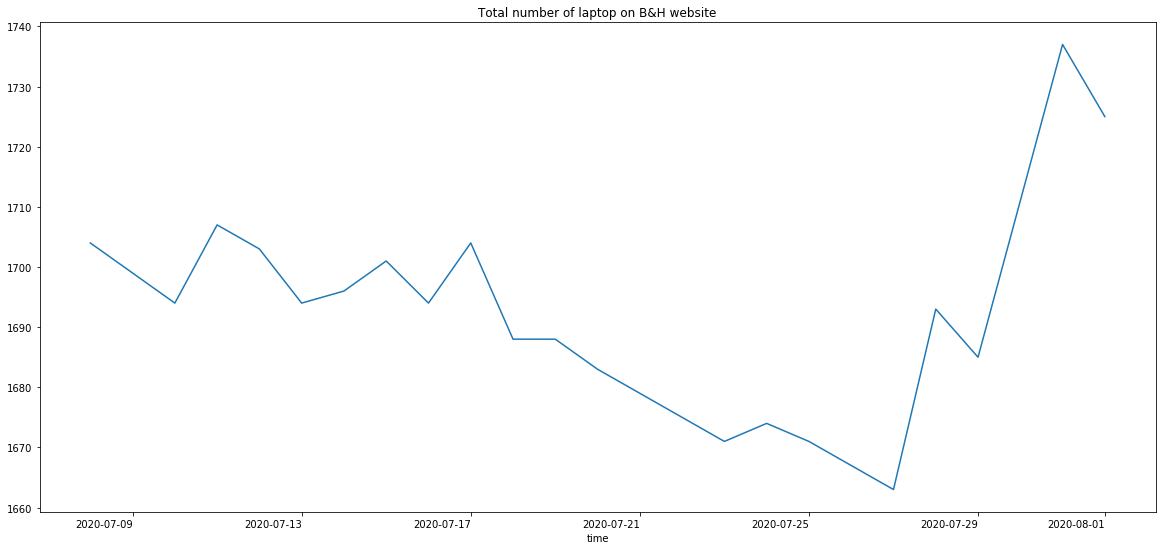

In [8]:
df.groupby(['time']).size().plot(figsize=(20,10), 
                 title='Total number of laptop on B&H website',
                 rot=0)
plt.show()

## further breaks down 'availability' column

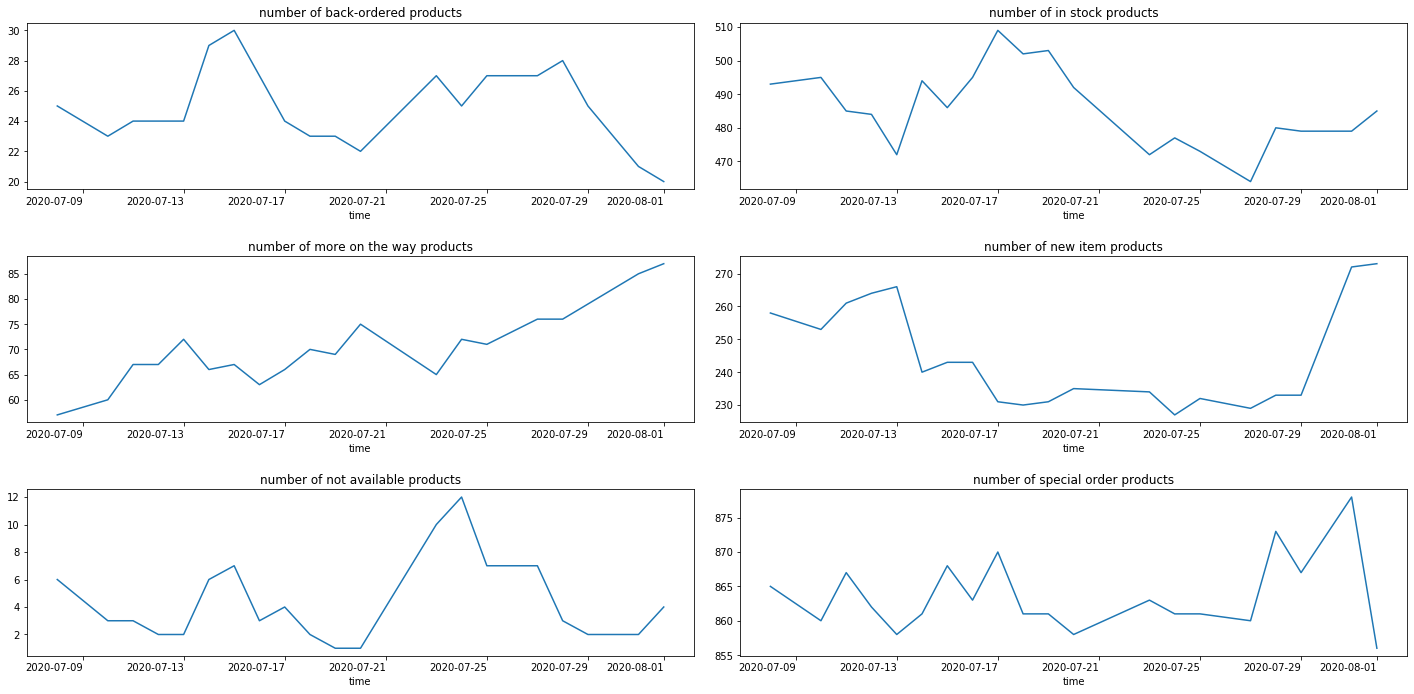

In [9]:
df_num = df.groupby(['time', 'availability']).size().unstack()

fig, ax = plt.subplots(3, 2, figsize=(20, 10))
col_size = df_num.shape[1]
cols = df_num.columns
for col_i in range(col_size):
    col = cols[col_i]
    df_num[col].plot(title='number of {} products'.format(col),
                     rot=0, ax=ax[int(col_i/2)][col_i%2])
fig.tight_layout(pad=2.0)
plt.show()

## median price per each brand

In [10]:
# brand segments based on average price
avg_price_per_brand = df.groupby(['brand_name'])['price'].mean()

low_end_brand = avg_price_per_brand[avg_price_per_brand < 1000].index

median_end1 = avg_price_per_brand[(avg_price_per_brand < 1500) & (avg_price_per_brand >= 1000)].index

median_end2 = avg_price_per_brand[(avg_price_per_brand < 2000) & (avg_price_per_brand >= 1500)].index

high_end1 = avg_price_per_brand[(avg_price_per_brand < 2500) & (avg_price_per_brand >= 2000)].index

high_end2 = avg_price_per_brand[avg_price_per_brand >= 2500].index

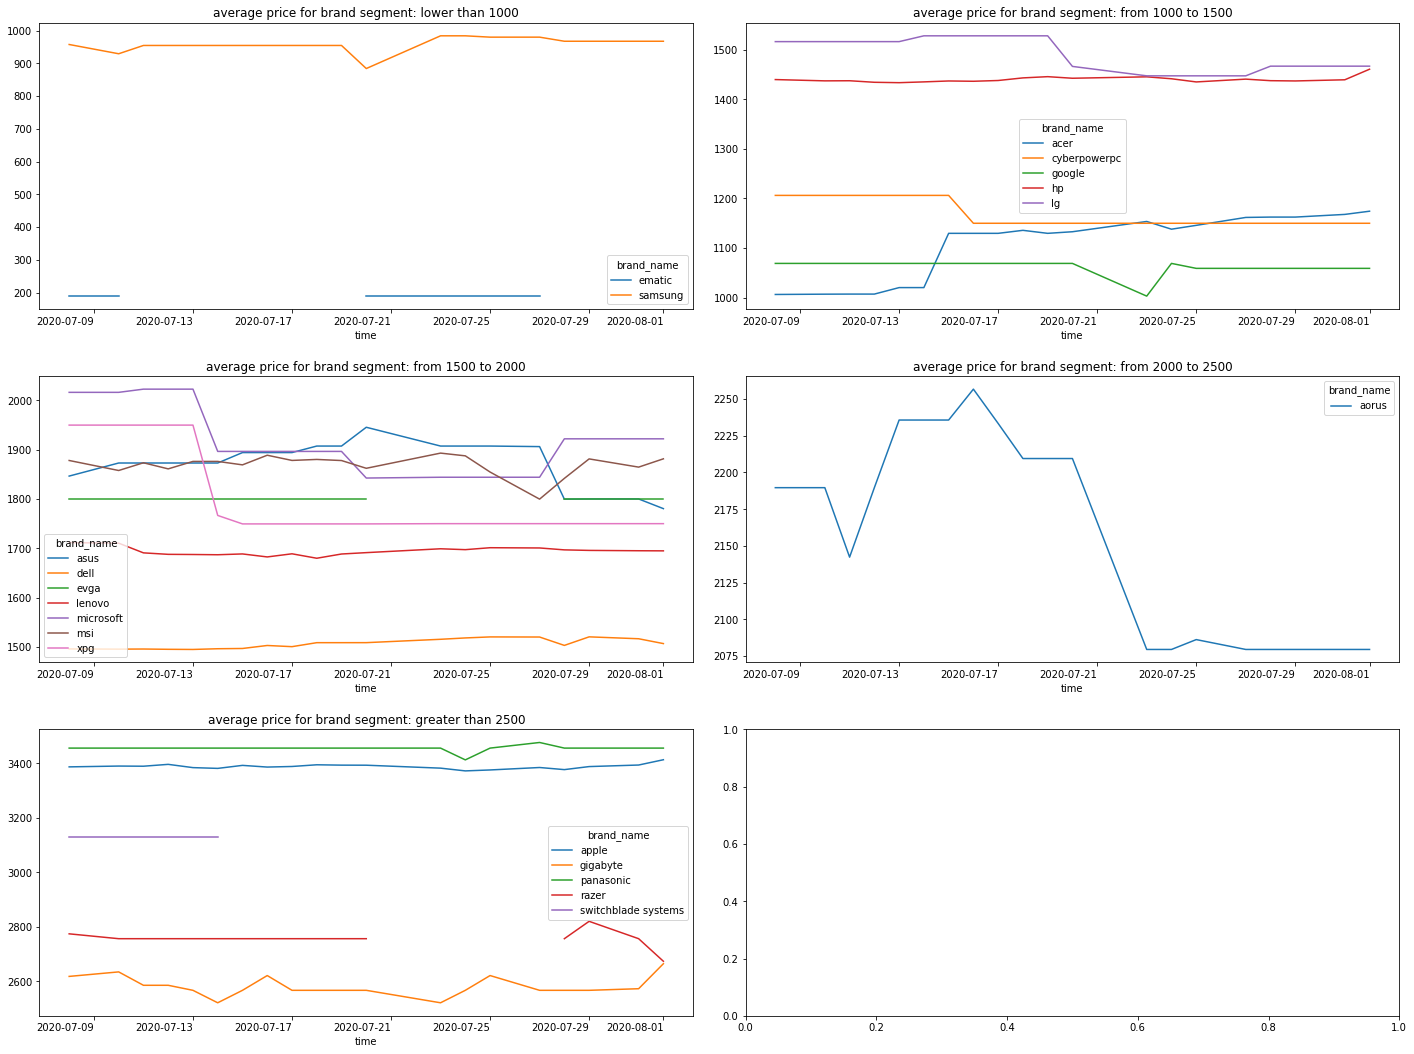

In [11]:
# average price per brand for each day
avg_price_brand_dt = df.groupby(['time', 'brand_name'])['price'].mean().unstack()
brand_segment = ['lower than 1000', 'from 1000 to 1500', 'from 1500 to 2000', 'from 2000 to 2500', 'greater than 2500']
brand_list = [low_end_brand, median_end1, median_end2, high_end1, high_end2]

fig, ax = plt.subplots(3, 2, figsize=(20, 15))
for i in range(5):
    brands_select = brand_list[i]
    brand_seg = brand_segment[i]
    avg_price_brand_dt[brands_select].plot(title='average price for brand segment: {}'.format(brand_seg),
                     rot=0, ax=ax[int(i/2)][i%2])
fig.tight_layout(pad=2.0)
plt.show()